# Skin Conditions Model 2
This model is the model that used to classify user's skin conditions and have an output of multi-label class from 3 possible class (acne,eye_bags, redness)

## Import Libraries, Mobilenet, and Env File

In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report

In [4]:
# Importing Env File
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH_CONDITIONS_2')

In [3]:
# Importing MobileNetV2 Model With ImagNet Weight Without The Top Layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
# Membekukan semua lapisan dari model MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

In [5]:
# Fine-tuning: Membuka beberapa lapisan terakhir dari MobileNetV2
for layer in base_model.layers[-5:]:  # Mengatur lebih banyak lapisan terakhir dapat dilatih
    layer.trainable = True

## Importing Trained Model (If Exist)

In [5]:
from tensorflow.keras.models import load_model

# load model from .h5 file
model = load_model('models/skin_conditions_model_2.h5')

## Import Data and Data Augmentation

In [8]:
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import random

class SkinConditionsDataset(tfds.core.GeneratorBasedBuilder):
    """DatasetBuilder for skin condition detection."""

    VERSION = tfds.core.Version('1.0.0')
    MANUAL_DOWNLOAD_INSTRUCTIONS = "Please ensure the skin type dataset is downloaded and located at the right path (look at env file)"

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description=("Dataset for skin conditions classification with 2 labels: acne n eye_bags"),
            features=tfds.features.FeaturesDict({
                'image': tfds.features.Image(shape=(224, 224, 3)),
                'label': tfds.features.Tensor(shape=(3,), dtype=tf.float32),
            }),
            supervised_keys=('image', 'label'),
        )

    def _split_generators(self, dl_manager):
        path = dl_manager.manual_dir
        
        # Membaca semua gambar dan label
        all_data = []
        for category in ['acne', 'eye_bags', 'normal']:
            category_path = os.path.join(path, category)
            for filename in os.listdir(category_path):
                all_data.append((filename, category))

        # Membuat DataFrame
        df = pd.DataFrame(all_data, columns=['filename', 'label'])

        # Membagi data menjadi train, val, dan test
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 dari train untuk validasi

        return {
            'train': self._generate_examples(train_df, path),
            'val': self._generate_examples(val_df, path),
            'test': self._generate_examples(test_df, path),
        }

    def _generate_examples(self, dataframe, base_path):
        label_map = {
            'acne': [1, 0, 0],
            'eye_bags': [0, 1, 0],
            'normal': [0, 0, 1]
        }
        images_labels = []

        # Load images and their labels
        for _, row in dataframe.iterrows():
            image_path = os.path.join(base_path, row['label'], row['filename'])
            image = tf.io.read_file(image_path)  # Membaca file gambar
            image = tf.io.decode_image(image, channels=3)  # Decode gambar ke tensor
            image = tf.image.resize(image, (224, 224))  # Ubah ukuran gambar
            image = tf.cast(image, tf.uint8)  # Konversi tipe data ke uint8
            label = tf.cast(label_map[row['label']], tf.float32)  # Cast to float32
            images_labels.append((image, label))  # Tambahkan ke list

        # Generate standard examples
        for i, (image, label) in enumerate(images_labels):
            yield f"{label.numpy()}_{i}", {  # Mengubah label menjadi NumPy array sebelum yield
                'image': image.numpy(),
                'label': label.numpy(),  # Pastikan label adalah NumPy array
            }

        # Generate overlay examples
        for i in range(0, len(images_labels), 2):  # Ambil setiap 2 gambar
            selected_images = images_labels[i:i+2]  # Mengambil 2 gambar berturut-turut
            if len(selected_images) < 2:
                continue  # Skip jika tidak ada cukup gambar dalam kelompok
            
            # Buat variabel untuk menyimpan hasil pengecekan
            contains_normal = any(tf.reduce_all(label == [0, 0, 1]) for _, label in selected_images)

            if contains_normal:
                continue  # Skip kelompok gambar jika ada label "normal"
            
            # Pilih dua gambar acak dari kelompok untuk di-overlay
            random.shuffle(selected_images)
            image1, label1 = selected_images[0]
            image2, label2 = selected_images[1]

            # Pastikan kelas berbeda sebelum overlay
            if tf.reduce_sum(tf.abs(label1 - label2)) > 0:  # Pastikan label berbeda
                # Buat overlay hanya jika label berbeda
                combined_image, combined_label = self.overlay_two_data(image1, label1, image2, label2)
                combined_image = tf.cast(combined_image, tf.uint8)  # Pastikan konversi ke uint8 untuk overlay

                # Buat key unik untuk overlay
                unique_key = f"overlay_{i}_{i+1}"

                # Yield contoh baru untuk dataset
                yield unique_key, {
                    'image': combined_image.numpy(),
                    'label': combined_label.numpy(),  # Pastikan label adalah NumPy array
                }

    # Fungsi untuk menggabungkan dua gambar
    def overlay_two_images(self, image1, image2, alpha=0.5):
        # Resize kedua gambar ke ukuran yang sama
        image1 = tf.image.resize(image1, (224, 224))
        image2 = tf.image.resize(image2, (224, 224))

        # Gabungkan gambar dengan alpha untuk mengatur seberapa banyak kontribusi dari setiap gambar
        combined_image = (image1 * alpha) + (image2 * alpha)

        return combined_image

    # Fungsi untuk overlay dua data (label juga digabung)
    def overlay_two_data(self, image1, label1, image2, label2):
        combined_image = self.overlay_two_images(image1, image2)
        # Gabungkan label dengan mengambil nilai maksimum untuk setiap kelas
        combined_label = tf.maximum(label1, label2)
        return combined_image, combined_label


# Use the updated dataset class
builder = SkinConditionsDataset(data_dir=datasets_path)
builder.download_and_prepare()

## Checking Dataset

In [9]:
# Memuat dataset dalam bentuk builder untuk melakukan cek
ds_train = builder.as_dataset(split='train')
ds_val = builder.as_dataset(split='val')
ds_test = builder.as_dataset(split='test')

In [10]:
# Filter dan tampilkan label dengan nilai [1, 1, 0]
for i, example in enumerate(ds_train):
    label = example['label'].numpy()  # Ambil label sebagai numpy array
    # print(f"Label {i + 1}: {label}")
    if (label == [1, 1, 0]).all():    
        print(f"Label {i + 1}: {label}")

Label 26: [1. 1. 0.]
Label 34: [1. 1. 0.]
Label 46: [1. 1. 0.]
Label 66: [1. 1. 0.]
Label 70: [1. 1. 0.]
Label 79: [1. 1. 0.]
Label 87: [1. 1. 0.]
Label 96: [1. 1. 0.]
Label 106: [1. 1. 0.]
Label 116: [1. 1. 0.]
Label 141: [1. 1. 0.]
Label 151: [1. 1. 0.]
Label 166: [1. 1. 0.]
Label 174: [1. 1. 0.]
Label 178: [1. 1. 0.]
Label 189: [1. 1. 0.]
Label 202: [1. 1. 0.]
Label 222: [1. 1. 0.]
Label 253: [1. 1. 0.]
Label 259: [1. 1. 0.]
Label 282: [1. 1. 0.]
Label 305: [1. 1. 0.]
Label 310: [1. 1. 0.]
Label 315: [1. 1. 0.]
Label 318: [1. 1. 0.]
Label 326: [1. 1. 0.]
Label 334: [1. 1. 0.]
Label 337: [1. 1. 0.]
Label 351: [1. 1. 0.]
Label 367: [1. 1. 0.]
Label 368: [1. 1. 0.]
Label 371: [1. 1. 0.]
Label 392: [1. 1. 0.]
Label 398: [1. 1. 0.]


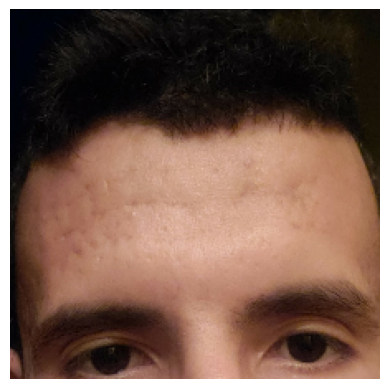

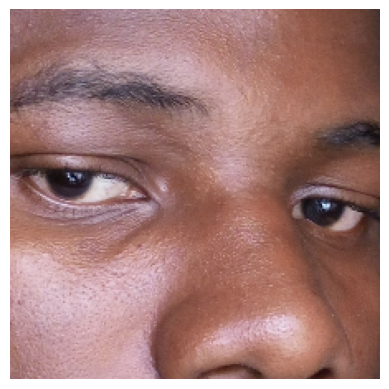

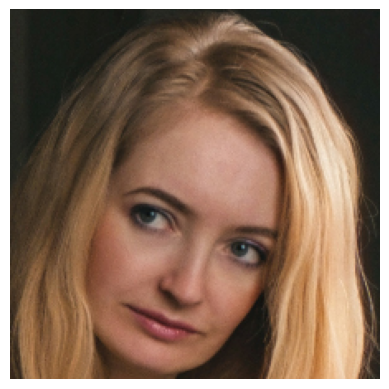

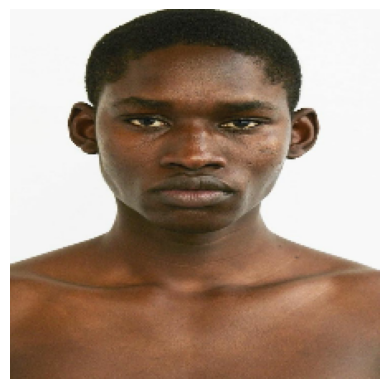

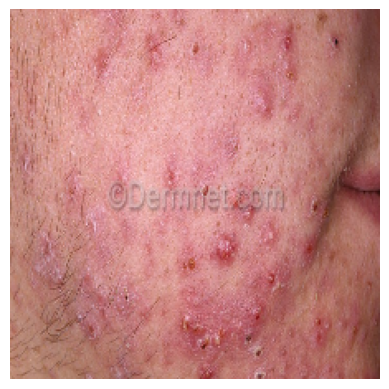

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Fungsi untuk menampilkan gambar
def show_image(image):
    # Konversi gambar tensor ke numpy array dan tampilkan dengan matplotlib
    image = image.numpy()  # Ubah tensor menjadi numpy array
    plt.imshow(image)
    plt.axis('off')  # Nonaktifkan axis
    plt.show()

# Fungsi untuk menampilkan beberapa gambar
def show_images_from_dataset(dataset, num_images=5):
    for i, data in enumerate(dataset.take(num_images)):  # Ambil beberapa gambar pertama dari dataset
        image = data['image']
        # Tampilkan gambar
        show_image(image)

# Menampilkan gambar pertama dari ds_train
show_images_from_dataset(ds_train, num_images=5)


## Loading The Dataset And Data Augmentation

In [12]:
# Memuat dataset yang sudah diproses
ds_train = tfds.load('skin_conditions_dataset', split='train', data_dir=datasets_path)
ds_val = tfds.load('skin_conditions_dataset', split='val', data_dir=datasets_path)
ds_test = tfds.load('skin_conditions_dataset', split='test', data_dir=datasets_path)

In [13]:
def augment_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Menambahkan random zoom
    scale = tf.random.uniform(shape=[], minval=0.8, maxval=1.2, dtype=tf.float32)
    new_height = tf.cast(scale * 224, tf.int32)
    new_width = tf.cast(scale * 224, tf.int32)
    image = tf.image.resize(image, (new_height, new_width))
    image = tf.image.resize_with_crop_or_pad(image, 224, 224)  # Mengembalikan ke ukuran 224x224
    
    return image, label

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Function to ensure data is paired as (image, label)
def preprocess(data):
    image = data['image']
    label = data['label']
    return image, label

# Apply preprocessing and augmentation
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets
ds_train = ds_train.batch(16).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(16).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(16).prefetch(tf.data.AUTOTUNE)


In [18]:
# Hitung jumlah data dalam ds_train
num_samples = sum(1 for _ in ds_train)
# num_samples = sum(1 for _ in ds_train.unbatch())

print(f"Jumlah gambar dan label dalam ds_train: {num_samples}")

Jumlah gambar dan label dalam ds_train: 26


## Creating The Model

In [19]:
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Menambahkan lapisan kustom di atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)  # ReLU activation setelah batch normalization
x = Dropout(0.5)(x)
outputs = Dense(3, activation='sigmoid', kernel_regularizer=l2(0.01))(x)  # Menggunakan sigmoid untuk multi-label classification

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Menyesuaikan optimizer dan learning rate 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) 
# Compiling the model 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Show Model Architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,917,443 (11.13 MB)

 Trainable params: 1,378,435 (5.26 MB)

 Non-trainable params: 1,539,008 (5.87 MB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback untuk menghentikan pelatihan jika validasi loss tidak membaik
early_stopping = EarlyStopping(
    monitor='val_loss',                  
    patience=5,                         
    restore_best_weights=True,           
    verbose=1                            
)

# Callback untuk mengurangi learning rate jika validasi loss stagnan
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',                
    factor=0.5,                         
    patience=3,                         
    verbose=1                           
)

In [22]:
for image, label in ds_train.take(1):
    print(image.shape, label.shape)  # Pastikan gambar memiliki shape ((batch size), 224, 224, 3)

(16, 224, 224, 3) (16, 3)


## Train Model

Epoch 1/45
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.4511 - loss: 8.0679 - val_accuracy: 0.8088 - val_loss: 7.7289 - learning_rate: 0.0010
Epoch 2/45
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.8096 - loss: 7.6916 - val_accuracy: 0.8309 - val_loss: 7.5967 - learning_rate: 0.0010
Epoch 3/45
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.8595 - loss: 7.5281 - val_accuracy: 0.8309 - val_loss: 7.4696 - learning_rate: 0.0010
Epoch 4/45
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.8818 - loss: 7.4487 - val_accuracy: 0.8382 - val_loss: 7.3964 - learning_rate: 0.0010
Epoch 5/45
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.8668 - loss: 7.3339 - val_accuracy: 0.8382 - val_loss: 7.3051 - learning_rate: 0.0010
Epoch 6/45
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.8955 - loss: 7.2530 - val_accuracy: 0.8529 - val_loss: 7.2201 - learning_rate: 0.0010
Epoch 7/45
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.8685 - loss: 7.1713 - 

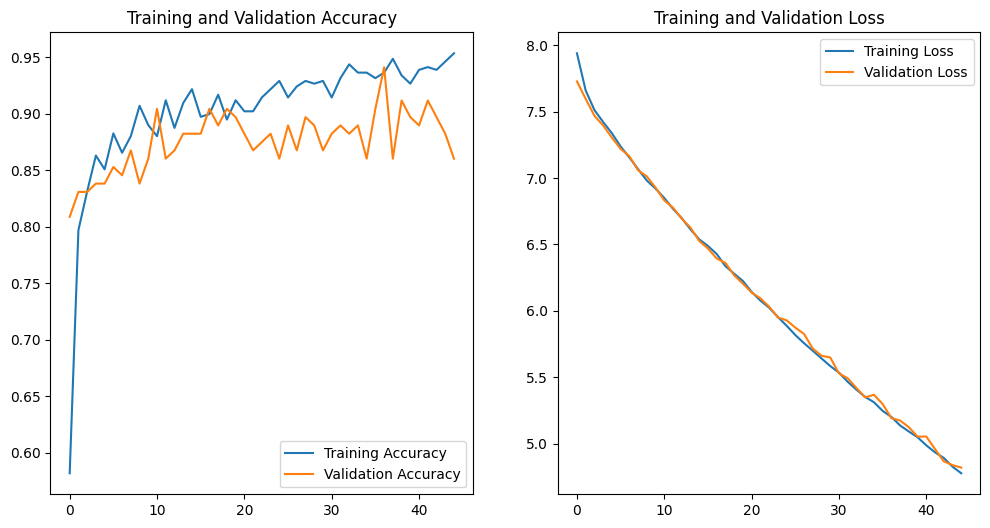

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8540 - loss: 4.8808
Testing Loss: 4.845902919769287, Testing Accuracy: 0.881118893623352


In [23]:
# class_weight = {0: 0.85, 1: 1.2}  # Sesuaikan bobot berdasarkan kinerja kelas

# Melatih model dan mencatat hasil pelatihan dalam objek `history`
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=45,
    # class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler] 
)

# Menampilkan metrik dengan matplotlib
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model pada data testing
loss, accuracy = model.evaluate(ds_test)
print(f'Testing Loss: {loss}, Testing Accuracy: {accuracy}')


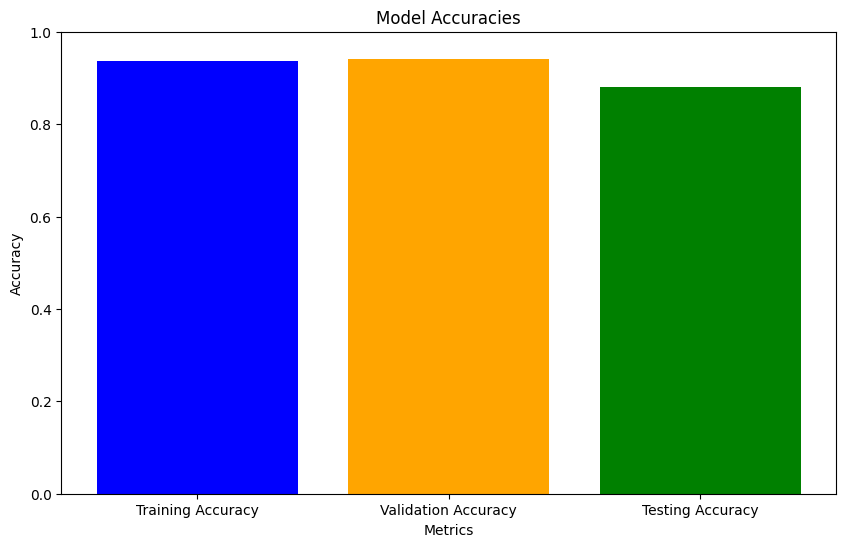

In [24]:
# Ambil nilai akurasi pada epoch terbaik
best_epoch = np.argmax(history.history['val_accuracy'])

train_accuracy = history.history['accuracy'][best_epoch] 
val_accuracy = history.history['val_accuracy'][best_epoch]

# Akurasi data testing (sudah didapat dari evaluasi model sebelumnya)
test_accuracy = accuracy

# Buat bar chart
labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, val_accuracy, test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  # Atur batas y dari 0 sampai 1
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step


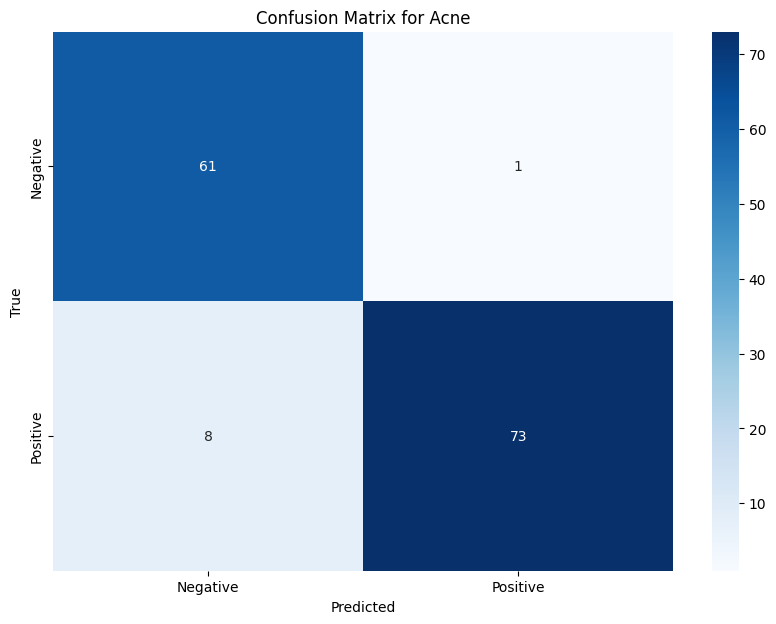

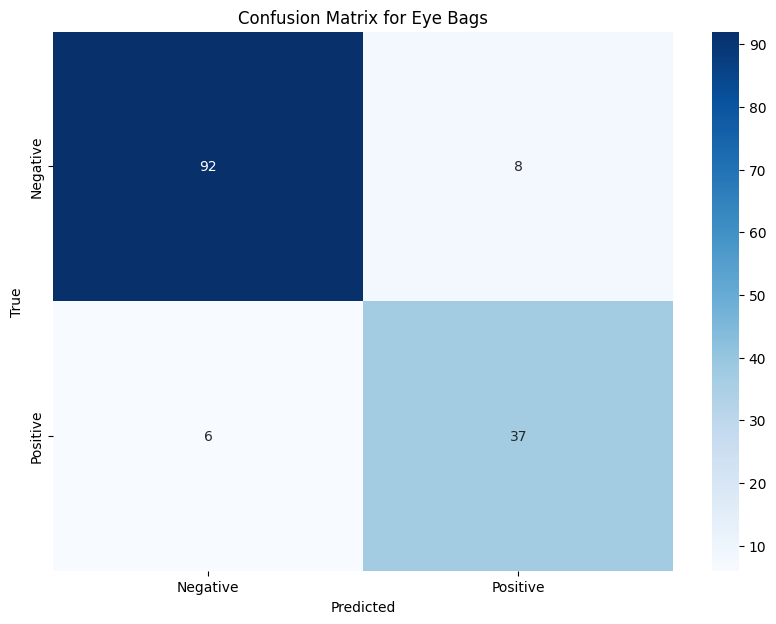

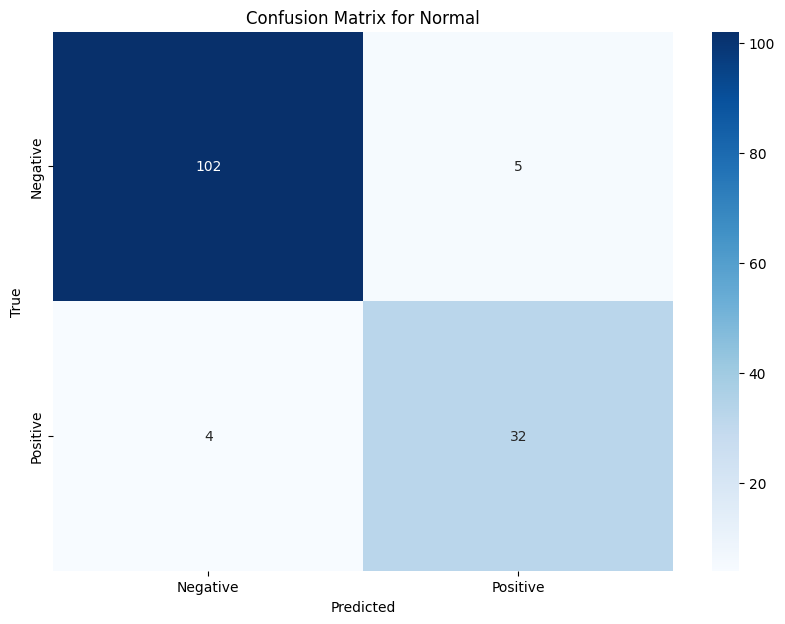

              precision    recall  f1-score   support

        Acne       0.99      0.90      0.94        81
    Eye Bags       0.82      0.86      0.84        43
      Normal       0.86      0.89      0.88        36

   micro avg       0.91      0.89      0.90       160
   macro avg       0.89      0.88      0.89       160
weighted avg       0.91      0.89      0.90       160
 samples avg       0.91      0.90      0.90       160



c:\Users\albia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Mengubah prediksi menjadi biner

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)

# Menghitung multilabel confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred_binary)

# Menampilkan confusion matrix untuk masing-masing label
labels = ['Acne', 'Eye Bags', 'Normal']
for i, label in enumerate(labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true, y_pred_binary, target_names=labels))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step


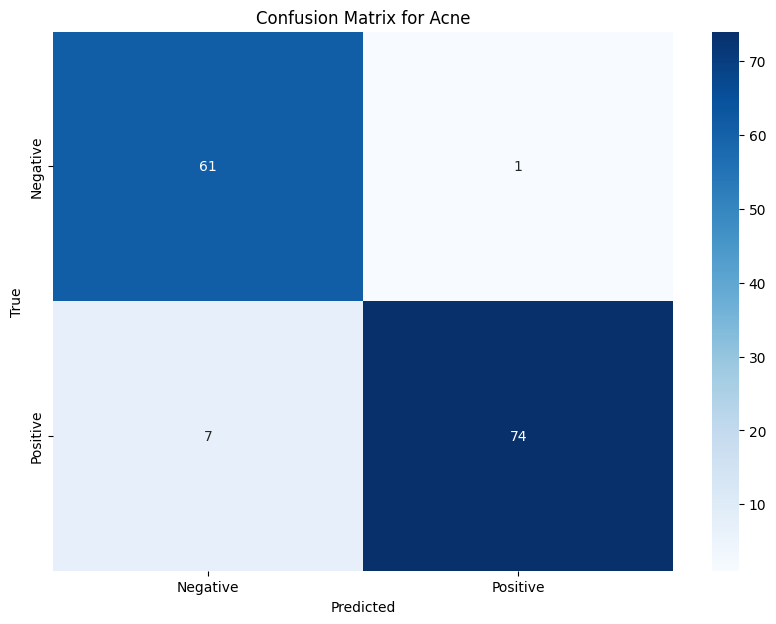

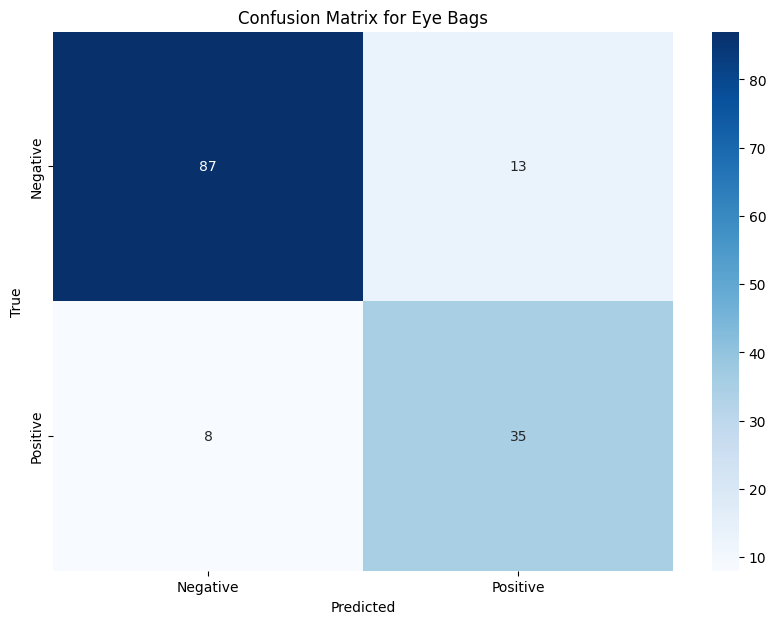

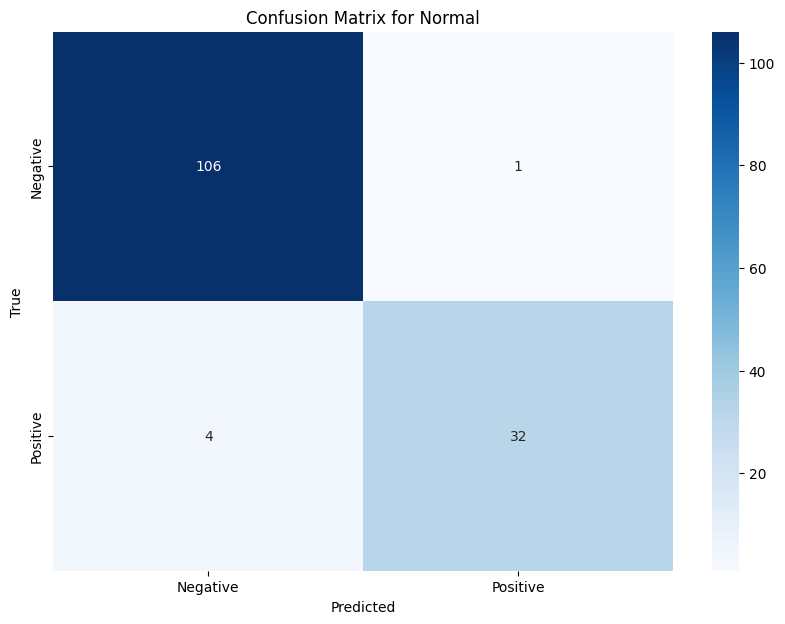

              precision    recall  f1-score   support

        Acne       0.99      0.91      0.95        81
    Eye Bags       0.73      0.81      0.77        43
      Normal       0.97      0.89      0.93        36

   micro avg       0.90      0.88      0.89       160
   macro avg       0.90      0.87      0.88       160
weighted avg       0.91      0.88      0.90       160
 samples avg       0.89      0.90      0.89       160



c:\Users\albia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Mengubah prediksi menjadi biner

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)

# Menghitung multilabel confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred_binary)

# Menampilkan confusion matrix untuk masing-masing label
labels = ['Acne', 'Eye Bags', 'Normal']
for i, label in enumerate(labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true, y_pred_binary, target_names=labels))


In [17]:
# Saving the model in .h5 format
model.save('models/skin_conditions_model.keras')

In [2]:
import tensorflow as tf

# Load model dari file .keras
model = tf.keras.models.load_model('models/skin_conditions_model.keras')

# Buat converter untuk mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('models/skin_conditions_model.tflite', 'wb') as f:
    f.write(tflite_model)

c:\Users\albia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmpjin526e3\assets


INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmpjin526e3\assets


Saved artifact at 'C:\Users\albia\AppData\Local\Temp\tmpjin526e3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2980911589776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911591888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911592656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911592272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911591120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911592080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911593616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911593040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911594000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2980911592848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  298091